In [1]:
import os
import sys
import uproot
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")

from processing import kinematics
from ttbar_reconstruction import neutrino_four_momentum, four_momentum

In [2]:
base_path = "../reconstructions/SM_spin-ON_100k"
reco_names = [
    "p_top", "p_l_t", "p_b_t", "p_nu_t",
    "p_tbar", "p_l_tbar", "p_b_tbar", "p_nu_tbar", "idx", "weight"
]
batches = {name: [] for name in reco_names}

for batch_idx in range(10):
    for name in reco_names:
        batches[name].append(np.load(os.path.join(base_path, f"{name}_batch_{batch_idx}.npy")))

arrays = {name: np.concatenate(batches, axis=0) for name, batches in batches.items()}

idx_mask = arrays["idx"].reshape(-1)

In [3]:
events_path = "../mg5_data/SM-process_spin-ON_100k/Events/run_01_decayed_1/tag_1_delphes_events.root"
events = uproot.open(events_path)["Delphes"]

## Neutrino

In [4]:
nu_e_t_mask = (
    (events["Particle.PID"].array() == 12) * (events["Particle.Status"].array() == 1)
)
px = events["Particle.Px"].array()[nu_e_t_mask][idx_mask].flatten()
py = events["Particle.Py"].array()[nu_e_t_mask][idx_mask].flatten()
pz = events["Particle.Pz"].array()[nu_e_t_mask][idx_mask].flatten()
E = events["Particle.E"].array()[nu_e_t_mask][idx_mask].flatten()

phi = events["Particle.Phi"].array()[nu_e_t_mask][idx_mask].flatten()
eta = events["Particle.Eta"].array()[nu_e_t_mask][idx_mask].flatten()

In [5]:
p_true = np.stack([px, py, pz, E], axis=1)

../processing/kinematics.py:25: RuntimeWarning: divide by zero encountered in true_divide
  return -0.5 * np.log((1 - cos_theta) / (1 + cos_theta))


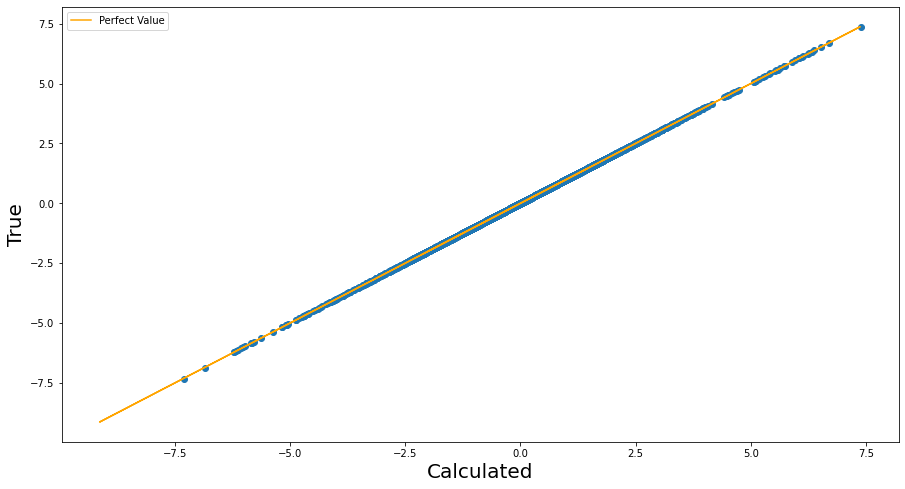

In [6]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.scatter(kinematics.eta(p_true), eta)
plt.plot(eta, eta, color="orange", label="Perfect Value")
plt.xlabel("Calculated", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.legend()

In [7]:
def neutrino_four_momentum(px: float, py: float, eta: float) -> np.ndarray:
    """Generate neutrino's four momentum.

    :param px: momentum's x component.
    :type px: float
    :param py: momentum's y component.
    :type py: float
    :param eta: Pseudorapidity.
    :type eta: float
    :return: Four momentum in (x, y, z, E) coordinates.
    :rtype: np.ndarray
    """
    pt = np.sqrt(px**2 + py**2)
    pz = pt * np.sinh(eta)
    E = pt * np.cosh(eta)
    return np.concatenate([px, py, pz, E], axis=1)

In [8]:
p_calc = neutrino_four_momentum(
    px=px.reshape(-1, 1),
    py=py.reshape(-1, 1),
    eta=eta.reshape(-1, 1)
)

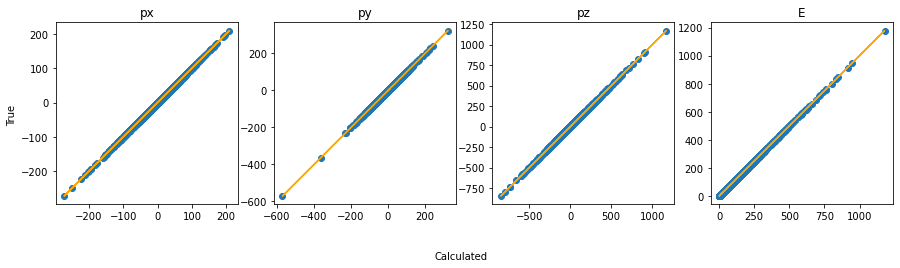

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 8))

idx_to_label = {0: "px", 1: "py", 2: "pz", 3: "E"}

for idx in range(p_calc.shape[1]):
    ax[idx].scatter(p_calc[:, idx], p_true[:, idx])
    ax[idx].plot(p_true[:, idx], p_true[:, idx], color="orange", label="Perfect ")
    ax[idx].set_aspect('equal', 'box')
    ax[idx].set_title(idx_to_label[idx])
    
fig.text(0.5, 0.25, 'Calculated', ha='center')
fig.text(0.08, 0.5, 'True', va='center', rotation='vertical');